# Topic Models

In [1]:
import pandas as pd

In [6]:
df = pd.read_excel('../data/wine_reviews.xlsx', encoding='utf8')
len(df)

150925

In [7]:
df.head()

,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,variety,winery,description_cleaned
0,0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hail be age year oak ...
1,1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aroma fig blackberry cassis be soften swe...
2,2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,honor memory wine once make his mother tremend...
3,3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,spend month new french oak incorporate fruit v...
4,4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,be top wine name high point vineyard foot have...


In [ ]:
# import spacy
# nlp = spacy.load('en')
# def clean(text):
#     return ' '.join([token.lemma_ 
#             for token in nlp(text) 
#             if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}])

# clean('Here is an example test of it for me.')

# df['description_cleaned'] = df.descrition.apply(clean)

# df.to_excel('../data/wine_reviews.xlsx', encoding='utf8')

In [11]:
# remove empty entries
df = df[df['description_cleaned'].notnull()]
len(df)

150922

## LDA

In [12]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [14]:
# get dictionary
df['description_cleaned'] = df.description_cleaned.apply(str)
# run on 50000 instances
instances = df.description_cleaned.apply(str.split)[:50000]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.1)
print(dictionary, flush=True)

creating dictionary
Dictionary(1251 unique tokens: ['age', 'background', 'balanced', 'caramel', 'compelling']...)


In [15]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [16]:
instances[0], ldacorpus[0], model_corpus[0]

(['tremendous',
  'varietal',
  'wine',
  'hail',
  'be',
  'age',
  'year',
  'oak',
  'red',
  'cherry',
  'fruit',
  'compelling',
  'hint',
  'caramel',
  'greet',
  'palate',
  'frame',
  'elegant',
  'fine',
  'tannin',
  'subtle',
  'minty',
  'tone',
  'background',
  'balanced',
  'rewarding',
  'start',
  'finish',
  'have',
  'year',
  'ahead',
  'develop',
  'further',
  'nuance',
  'enjoy'],
 [(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 2)],
 [(0, 0.13791563061137083),
  (1, 0.2685548749219632),
  (2, 0.20728117023183848),
  (3, 0.2209909524738622),
  (4, 0.30521172451813944),
  (5, 0.2157631148856043),
  (6, 0.17690462984557007),
  (7, 0.23350436925864565),
  (8, 0.16455237177336218),
  (9, 0.22905815166309088),
  (10, 0.2853160426421291),
  (11, 0.1409847327539356),
  (12, 0.2724827547913376),
  (13, 0.25298291209149926),
  

## Choosing the number of topics

In [53]:
coherence_values = []
model_list = []
for num_topics in range(5, 21):
    print(num_topics)
    model = LdaMulticore(corpus=model_corpus[:10000], id2word=dictionary, num_topics=num_topics)
    model_list.append(model)
    coherencemodel_umass = CoherenceModel(model=model, texts=instances[10000:15000], dictionary=dictionary, coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, texts=instances[10000:15000], dictionary=dictionary, coherence='c_v')

    coherence_values.append((num_topics, coherencemodel_umass.get_coherence(), coherencemodel_cv.get_coherence()))

INFO:gensim.models.ldamodel:using symmetric alpha at 0.2
INFO:gensim.models.ldamodel:using symmetric eta at 0.2
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 5 topics, 1 passes over the supplied corpus of 10000 documents, updating every 14000 documents, evaluating every ~10000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamulticore:training LDA model using 7 processes


5


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 4
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 4
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.007*"firm" + 0.006*"bodied" + 0.006*"vanilla" + 0.005*"structure" + 0.005*"juicy" + 0.005*"pepper" + 0.005*"fruity" + 0.005*"wood" + 0.005*"age" + 0.005*"texture"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.008*"apple" + 0.007*"light" + 0.006*"lemon" + 0.006*"fruity" + 0.006*"texture" + 0.005*"pear" + 0.005*"green" 

6


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 4
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 4
INFO:gensim.models.ldamodel:topic #4 (0.167): 0.007*"bodied" + 0.006*"texture" + 0.005*"hint" + 0.005*"light" + 0.005*"dark" + 0.005*"apple" + 0.005*"touch" + 0.005*"lemon" + 0.005*"medium" + 0.005*"crisp"
INFO:gensim.models.ldamodel:topic #5 (0.167): 0.007*"apple" + 0.007*"bodied" + 0.006*"light" + 0.006*"lemon" + 0.005*"medium" + 0.005*"texture" + 0.005*"balance" +

7


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 4
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 4
INFO:gensim.models.ldamodel:topic #4 (0.143): 0.007*"juicy" + 0.007*"apple" + 0.006*"bodied" + 0.006*"light" + 0.005*"white" + 0.005*"dark" + 0.005*"give" + 0.005*"texture" + 0.005*"young" + 0.004*"wood"
INFO:gensim.models.ldamodel:topic #0 (0.143): 0.007*"bodied" + 0.006*"apple" + 0.006*"fruity" + 0.006*"light" + 0.006*"crisp" + 0.005*"bright" + 0.005*"texture" + 0.

8


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 4
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 4
INFO:gensim.models.ldamodel:topic #0 (0.125): 0.007*"make" + 0.006*"bodied" + 0.006*"hint" + 0.005*"pepper" + 0.005*"apple" + 0.005*"juicy" + 0.005*"dark" + 0.005*"tannic" + 0.005*"white" + 0.005*"light"
INFO:gensim.models.ldamodel:topic #1 (0.125): 0.006*"apple" + 0.005*"texture" + 0.005*"herb" + 0.005*"dark" + 0.005*"touch" + 0.005*"juicy" + 0.005*"pepper" + 0.005*

9


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 4
INFO:gensim.models.ldamodel:topic #4 (0.111): 0.008*"apple" + 0.006*"juicy" + 0.006*"crisp" + 0.006*"bright" + 0.006*"citrus" + 0.006*"lemon" + 0.006*"white" + 0.005*"bodied" + 0.005*"hint" + 0.005*"fruity"
INFO:gensim.models.ldamodel:topic #8 (0.111): 0.007*"balance" + 0.006*"light" + 0.005*"apple" + 0.005*"juicy" + 0.005*"bodied" + 0.005*"fruity" + 0.005*"hint" + 0

10


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #0 (0.100): 0.006*"apple" + 0.006*"bright" + 0.006*"lemon" + 0.005*"texture" + 0.005*"give" + 0.005*"tart" + 0.005*"crisp" + 0.005*"make" + 0.005*"pear" + 0.005*"fruity"
INFO:gensim.models.ldamodel:topic #8 (0.100): 0.006*"apple" + 0.006*"white" + 0.006*"lemon" + 0.005*"texture" + 0.005*"give" + 0.005*"juicy" + 0.005*"balance" + 0.00

11


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #1 (0.091): 0.006*"bodied" + 0.006*"bright" + 0.006*"lemon" + 0.006*"juicy" + 0.005*"light" + 0.005*"apple" + 0.005*"hint" + 0.005*"fruity" + 0.005*"ready" + 0.005*"vanilla"
INFO:gensim.models.ldamodel:topic #4 (0.091): 0.008*"apple" + 0.006*"lemon" + 0.006*"light" + 0.005*"crisp" + 0.005*"pear" + 0.005*"texture" + 0.005*"citrus" + 0

12


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 4
INFO:gensim.models.ldamodel:topic #4 (0.083): 0.006*"apple" + 0.006*"light" + 0.005*"make" + 0.005*"come" + 0.005*"bodied" + 0.005*"herb" + 0.005*"hint" + 0.005*"touch" + 0.005*"citrus" + 0.005*"raspberry"
INFO:gensim.models.ldamodel:topic #10 (0.083): 0.007*"apple" + 0.007*"white" + 0.006*"juicy" + 0.006*"pepper" + 0.006*"bodied" + 0.006*"medium" + 0.005*"lemon" + 0

13


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #0 (0.077): 0.006*"dark" + 0.006*"firm" + 0.005*"texture" + 0.005*"pepper" + 0.005*"juicy" + 0.005*"tannic" + 0.005*"herb" + 0.005*"age" + 0.005*"bodied" + 0.005*"come"
INFO:gensim.models.ldamodel:topic #7 (0.077): 0.007*"light" + 0.006*"apple" + 0.006*"bodied" + 0.005*"give" + 0.005*"crisp" + 0.005*"smooth" + 0.005*"peach" + 0.005*"

14


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #13 (0.071): 0.006*"apple" + 0.006*"light" + 0.005*"vineyard" + 0.005*"bodied" + 0.005*"crisp" + 0.005*"dark" + 0.005*"come" + 0.005*"character" + 0.005*"hint" + 0.005*"give"
INFO:gensim.models.ldamodel:topic #6 (0.071): 0.005*"white" + 0.005*"raspberry" + 0.005*"vanilla" + 0.005*"fruity" + 0.005*"well" + 0.005*"peach" + 0.005*"peppe

15


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #13 (0.067): 0.007*"apple" + 0.005*"bodied" + 0.005*"white" + 0.005*"juicy" + 0.005*"hint" + 0.005*"lemon" + 0.005*"whiff" + 0.005*"crisp" + 0.005*"touch" + 0.005*"flower"
INFO:gensim.models.ldamodel:topic #4 (0.067): 0.009*"apple" + 0.007*"light" + 0.006*"texture" + 0.006*"yellow" + 0.005*"lemon" + 0.005*"give" + 0.005*"crisp" + 0.0

16


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #0 (0.062): 0.007*"texture" + 0.005*"hint" + 0.005*"herb" + 0.005*"give" + 0.005*"bodied" + 0.005*"apple" + 0.005*"vanilla" + 0.005*"firm" + 0.005*"citrus" + 0.005*"peach"
INFO:gensim.models.ldamodel:topic #9 (0.062): 0.006*"light" + 0.005*"herb" + 0.005*"raspberry" + 0.005*"lemon" + 0.005*"bodied" + 0.005*"lead" + 0.005*"hint" + 0.0

17


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #12 (0.059): 0.006*"light" + 0.006*"bright" + 0.005*"raspberry" + 0.005*"vanilla" + 0.005*"juicy" + 0.005*"tart" + 0.005*"make" + 0.005*"white" + 0.005*"peach" + 0.005*"hint"
INFO:gensim.models.ldamodel:topic #7 (0.059): 0.006*"apple" + 0.006*"lemon" + 0.005*"light" + 0.005*"still" + 0.005*"fruity" + 0.005*"white" + 0.005*"juicy" + 0

18


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #16 (0.056): 0.007*"touch" + 0.006*"give" + 0.006*"light" + 0.006*"pepper" + 0.006*"come" + 0.005*"apple" + 0.005*"crisp" + 0.005*"bodied" + 0.005*"herb" + 0.005*"white"
INFO:gensim.models.ldamodel:topic #13 (0.056): 0.007*"juicy" + 0.006*"apple" + 0.006*"structure" + 0.006*"white" + 0.005*"firm" + 0.005*"age" + 0.005*"pepper" + 0.00

19


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #13 (0.053): 0.007*"white" + 0.006*"citrus" + 0.006*"apple" + 0.006*"pepper" + 0.005*"peach" + 0.005*"as" + 0.005*"well" + 0.005*"herb" + 0.005*"lemon" + 0.005*"juicy"
INFO:gensim.models.ldamodel:topic #16 (0.053): 0.007*"white" + 0.006*"bodied" + 0.006*"come" + 0.006*"texture" + 0.006*"apple" + 0.005*"lemon" + 0.005*"hint" + 0.005*"

20


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/10000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/10000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/10000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/10000, outstanding queue size 3
INFO:gensim.models.ldamodel:topic #9 (0.050): 0.007*"apple" + 0.006*"lemon" + 0.006*"white" + 0.006*"light" + 0.005*"lead" + 0.005*"citrus" + 0.005*"crisp" + 0.005*"fruity" + 0.005*"hint" + 0.005*"bodied"
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.008*"light" + 0.007*"texture" + 0.006*"apple" + 0.006*"bodied" + 0.005*"touch" + 0.005*"bright" + 0.005*"lemon" + 0

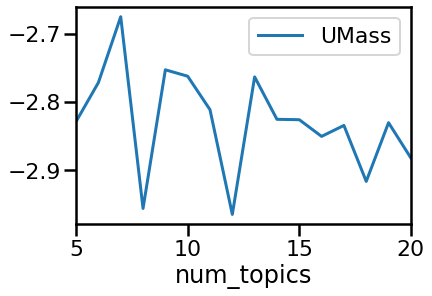

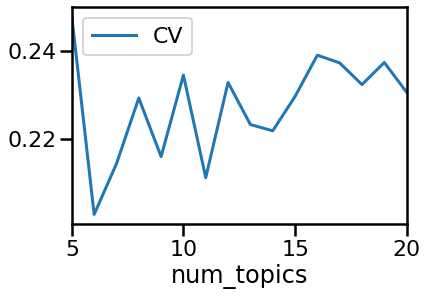

In [54]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
scores.plot.line(x='num_topics', y='UMass');
scores.plot.line(x='num_topics', y='CV');

In [55]:
num_topics = 6

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5
                    )
    
print("done in {}".format(time.time()-start), flush=True)


2500.0
fitting model


INFO:gensim.models.ldamodel:using symmetric eta at 0.16666666666666666
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamulticore:running online LDA training, 6 topics, 10 passes over the supplied corpus of 50000 documents, updating every 17500 documents, evaluating every ~50000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamulticore:training LDA model using 7 processes
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2500/50000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #5000/50000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #7500/50000, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #10000/50000, outstanding queue size 4
INFO:gensim.models.ldamulticore:PROGRESS:

INFO:gensim.models.ldamodel:topic #5 (0.500): 0.007*"juicy" + 0.006*"bright" + 0.005*"texture" + 0.005*"herb" + 0.005*"chocolate" + 0.005*"dark" + 0.005*"balance" + 0.005*"there" + 0.005*"give" + 0.005*"currant"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.006*"fine" + 0.005*"balance" + 0.005*"crisp" + 0.005*"year" + 0.005*"apple" + 0.004*"feel" + 0.004*"well" + 0.004*"dark" + 0.004*"toast" + 0.004*"come"
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.006*"white" + 0.006*"light" + 0.005*"well" + 0.005*"give" + 0.005*"citrus" + 0.005*"crisp" + 0.005*"apple" + 0.005*"green" + 0.005*"age" + 0.004*"peach"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.007*"bodied" + 0.007*"apple" + 0.005*"white" + 0.005*"pepper" + 0.005*"there" + 0.005*"dark" + 0.004*"well" + 0.004*"crisp" + 0.004*"citrus" + 0.004*"hint"
INFO:gensim.models.ldamodel:topic diff=0.046887, rho=0.213201
INFO:gensim.models.ldamulticore:PROGRESS: pass 1, dispatched chunk #10 = documents up to #27500/50000, outstanding queue 

INFO:gensim.models.ldamodel:topic #3 (0.500): 0.008*"touch" + 0.008*"light" + 0.006*"raspberry" + 0.006*"apple" + 0.005*"attractive" + 0.005*"fruity" + 0.005*"smooth" + 0.005*"citrus" + 0.005*"crisp" + 0.005*"vanilla"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.007*"fine" + 0.006*"year" + 0.006*"balance" + 0.005*"pineapple" + 0.005*"toast" + 0.005*"crisp" + 0.005*"vanilla" + 0.004*"feel" + 0.004*"apple" + 0.004*"well"
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.006*"white" + 0.006*"light" + 0.005*"green" + 0.005*"tart" + 0.005*"citrus" + 0.005*"crisp" + 0.005*"not" + 0.005*"peach" + 0.005*"give" + 0.005*"well"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.008*"bodied" + 0.007*"apple" + 0.005*"white" + 0.005*"pepper" + 0.005*"there" + 0.004*"hint" + 0.004*"medium" + 0.004*"yellow" + 0.004*"dark" + 0.004*"citrus"
INFO:gensim.models.ldamodel:topic diff=0.052672, rho=0.208514
INFO:gensim.models.ldamulticore:PROGRESS: pass 2, dispatched chunk #17 = documents up to #45000/50000, ou

INFO:gensim.models.ldamodel:topic #1 (0.500): 0.007*"pineapple" + 0.007*"fine" + 0.007*"year" + 0.007*"toast" + 0.006*"balance" + 0.005*"vanilla" + 0.005*"crisp" + 0.004*"tropical" + 0.004*"buttered" + 0.004*"alcohol"
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.006*"green" + 0.006*"tart" + 0.006*"light" + 0.006*"citrus" + 0.006*"white" + 0.005*"not" + 0.005*"crisp" + 0.005*"little" + 0.005*"herbal" + 0.005*"style"
INFO:gensim.models.ldamodel:topic diff=0.059684, rho=0.204124
INFO:gensim.models.ldamodel:-7.447 per-word bound, 174.5 perplexity estimate based on a held-out corpus of 2500 documents with 9133 words
INFO:gensim.models.ldamulticore:PROGRESS: pass 4, dispatched chunk #0 = documents up to #2500/50000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 4, dispatched chunk #1 = documents up to #5000/50000, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 4, dispatched chunk #2 = documents up to #7500/50000, outstanding queue size 3


INFO:gensim.models.ldamodel:topic #5 (0.500): 0.010*"structure" + 0.010*"dark" + 0.009*"chocolate" + 0.009*"juicy" + 0.009*"dense" + 0.009*"currant" + 0.008*"firm" + 0.008*"age" + 0.008*"year" + 0.008*"give"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.009*"bodied" + 0.008*"apple" + 0.008*"pepper" + 0.007*"white" + 0.007*"medium" + 0.006*"hint" + 0.006*"yellow" + 0.005*"lemon" + 0.005*"pear" + 0.005*"lead"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.009*"pineapple" + 0.008*"toast" + 0.008*"fine" + 0.007*"year" + 0.007*"vanilla" + 0.006*"balance" + 0.005*"tropical" + 0.005*"alcohol" + 0.005*"next" + 0.005*"jam"
INFO:gensim.models.ldamodel:topic #4 (0.500): 0.006*"cassis" + 0.006*"bright" + 0.006*"long" + 0.005*"feel" + 0.005*"texture" + 0.005*"touch" + 0.005*"lemon" + 0.005*"make" + 0.005*"herbal" + 0.005*"easy"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.011*"touch" + 0.011*"light" + 0.010*"attractive" + 0.009*"fruity" + 0.007*"crisp" + 0.007*"easy" + 0.007*"apple" + 0.007*"

INFO:gensim.models.ldamodel:merging changes from 17500 documents into a model of 50000 documents
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.009*"tart" + 0.009*"green" + 0.008*"herbal" + 0.007*"light" + 0.007*"not" + 0.007*"little" + 0.006*"citrus" + 0.006*"feel" + 0.006*"sharp" + 0.005*"crisp"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.013*"light" + 0.012*"touch" + 0.011*"attractive" + 0.011*"fruity" + 0.009*"crisp" + 0.009*"easy" + 0.008*"almond" + 0.008*"apple" + 0.007*"citrus" + 0.007*"smooth"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.010*"pineapple" + 0.009*"toast" + 0.008*"fine" + 0.008*"vanilla" + 0.007*"year" + 0.006*"balance" + 0.006*"alcohol" + 0.006*"tropical" + 0.006*"jam" + 0.006*"next"
INFO:gensim.models.ldamodel:topic #4 (0.500): 0.007*"cassis" + 0.006*"feel" + 0.006*"long" + 0.006*"bright" + 0.005*"touch" + 0.005*"meat" + 0.005*"texture" + 0.005*"bold" + 0.005*"jammy" + 0.005*"make"
INFO:gensim.models.ldamodel:topic #5 (0.500): 0.012*"structure" + 0.011*"

INFO:gensim.models.ldamodel:topic #1 (0.500): 0.011*"pineapple" + 0.010*"toast" + 0.009*"vanilla" + 0.008*"fine" + 0.007*"alcohol" + 0.007*"year" + 0.007*"tropical" + 0.006*"balance" + 0.006*"jam" + 0.006*"next"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.010*"pepper" + 0.009*"bodied" + 0.008*"white" + 0.008*"medium" + 0.007*"apple" + 0.007*"hint" + 0.006*"lead" + 0.006*"clove" + 0.006*"deliver" + 0.006*"open"
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.010*"green" + 0.010*"tart" + 0.009*"herbal" + 0.008*"not" + 0.008*"little" + 0.007*"sharp" + 0.007*"feel" + 0.007*"light" + 0.007*"bit" + 0.006*"citrus"
INFO:gensim.models.ldamodel:topic diff=0.078325, rho=0.188982
INFO:gensim.models.ldamodel:-7.342 per-word bound, 162.2 perplexity estimate based on a held-out corpus of 2500 documents with 9133 words
INFO:gensim.models.ldamulticore:PROGRESS: pass 8, dispatched chunk #0 = documents up to #2500/50000, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 8, dispa

INFO:gensim.models.ldamodel:merging changes from 17500 documents into a model of 50000 documents
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.011*"pineapple" + 0.011*"toast" + 0.010*"vanilla" + 0.008*"alcohol" + 0.008*"fine" + 0.007*"tropical" + 0.007*"jam" + 0.007*"new" + 0.007*"balance" + 0.006*"year"
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.011*"green" + 0.011*"tart" + 0.010*"herbal" + 0.008*"not" + 0.008*"little" + 0.007*"bit" + 0.007*"feel" + 0.007*"sharp" + 0.007*"light" + 0.006*"citrus"
INFO:gensim.models.ldamodel:topic #5 (0.500): 0.014*"structure" + 0.014*"age" + 0.013*"dark" + 0.012*"wood" + 0.012*"firm" + 0.012*"year" + 0.012*"currant" + 0.011*"give" + 0.011*"chocolate" + 0.011*"dense"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.016*"light" + 0.015*"touch" + 0.014*"fruity" + 0.013*"crisp" + 0.012*"attractive" + 0.010*"easy" + 0.010*"apple" + 0.010*"citrus" + 0.010*"bright" + 0.010*"pear"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.011*"pepper" + 0.010*"bodi

done in 107.03228378295898


In [56]:
# transform the data into topic distros
topic_corpus = model[model_corpus]

topic_corpus[0]

[(0, 0.09546895),
 (1, 0.12963714),
 (2, 0.17417671),
 (3, 0.117502585),
 (4, 0.28096336),
 (5, 0.20225124)]

In [57]:
model.print_topics()

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.012*"green" + 0.011*"tart" + 0.011*"herbal" + 0.009*"not" + 0.008*"little" + 0.008*"bit" + 0.008*"feel" + 0.007*"sharp" + 0.006*"citrus" + 0.006*"light"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.012*"pineapple" + 0.011*"toast" + 0.010*"vanilla" + 0.008*"alcohol" + 0.007*"fine" + 0.007*"tropical" + 0.007*"jam" + 0.007*"new" + 0.007*"next" + 0.006*"balance"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.011*"pepper" + 0.010*"bodied" + 0.009*"medium" + 0.008*"white" + 0.008*"hint" + 0.008*"lead" + 0.007*"deliver" + 0.007*"clove" + 0.007*"open" + 0.007*"herb"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.016*"light" + 0.015*"fruity" + 0.015*"touch" + 0.014*"crisp" + 0.013*"attractive" + 0.011*"easy" + 0.011*"bright" + 0.011*"citrus" + 0.011*"apple" + 0.010*"pear"
INFO:gensim.models.ldamodel:topic #4 (0.500): 0.010*"cassis" + 0.008*"feel" + 0.008*"meat" + 0.007*"pair" + 0.007*"long" + 0.007*"jammy" + 0.006*"bold" + 0.006*"spicy" + 0.0

[(0,
  '0.012*"green" + 0.011*"tart" + 0.011*"herbal" + 0.009*"not" + 0.008*"little" + 0.008*"bit" + 0.008*"feel" + 0.007*"sharp" + 0.006*"citrus" + 0.006*"light"'),
 (1,
  '0.012*"pineapple" + 0.011*"toast" + 0.010*"vanilla" + 0.008*"alcohol" + 0.007*"fine" + 0.007*"tropical" + 0.007*"jam" + 0.007*"new" + 0.007*"next" + 0.006*"balance"'),
 (2,
  '0.011*"pepper" + 0.010*"bodied" + 0.009*"medium" + 0.008*"white" + 0.008*"hint" + 0.008*"lead" + 0.007*"deliver" + 0.007*"clove" + 0.007*"open" + 0.007*"herb"'),
 (3,
  '0.016*"light" + 0.015*"fruity" + 0.015*"touch" + 0.014*"crisp" + 0.013*"attractive" + 0.011*"easy" + 0.011*"bright" + 0.011*"citrus" + 0.011*"apple" + 0.010*"pear"'),
 (4,
  '0.010*"cassis" + 0.008*"feel" + 0.008*"meat" + 0.007*"pair" + 0.007*"long" + 0.007*"jammy" + 0.006*"bold" + 0.006*"spicy" + 0.006*"bright" + 0.005*"baked"'),
 (5,
  '0.015*"structure" + 0.015*"age" + 0.013*"year" + 0.013*"dark" + 0.013*"wood" + 0.012*"currant" + 0.012*"firm" + 0.012*"give" + 0.011*"choco

In [58]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

INFO:gensim.models.ldamodel:topic #0 (0.500): 0.012*"green" + 0.011*"tart" + 0.011*"herbal" + 0.009*"not" + 0.008*"little"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.012*"pineapple" + 0.011*"toast" + 0.010*"vanilla" + 0.008*"alcohol" + 0.007*"fine"
INFO:gensim.models.ldamodel:topic #2 (0.500): 0.011*"pepper" + 0.010*"bodied" + 0.009*"medium" + 0.008*"white" + 0.008*"hint"
INFO:gensim.models.ldamodel:topic #3 (0.500): 0.016*"light" + 0.015*"fruity" + 0.015*"touch" + 0.014*"crisp" + 0.013*"attractive"
INFO:gensim.models.ldamodel:topic #4 (0.500): 0.010*"cassis" + 0.008*"feel" + 0.008*"meat" + 0.007*"pair" + 0.007*"long"
INFO:gensim.models.ldamodel:topic #5 (0.500): 0.015*"structure" + 0.015*"age" + 0.013*"year" + 0.013*"dark" + 0.013*"wood"


1 "green", "tart", "herbal", "not", "little"
2 "pineapple", "toast", "vanilla", "alcohol", "fine"
3 "pepper", "bodied", "medium", "white", "hint"
4 "light", "fruity", "touch", "crisp", "attractive"
5 "cassis", "feel", "meat", "pair", "long"
6 "structure", "age", "year", "dark", "wood"


## Aggregating topics by a dependent variable

In [59]:
target_category = 'country'
# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(50000)]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
# add the review category of each document (so we can aggregate)
topic_distros['category'] = df[target_category][:50000]

In [60]:
topic_distros.head()

,"green, tart","pineapple, toast","pepper, bodied","light, fruity","cassis, feel","structure, age",category
0,0.095447,0.130326,0.173504,0.117428,0.281361,0.201934,US
1,0.100738,0.262439,0.143218,0.101430,0.188960,0.203215,Spain
2,0.121956,0.257583,0.339901,0.101413,0.078019,0.101128,US
3,0.074404,0.241235,0.327179,0.150074,0.084712,0.122395,US
4,0.074916,0.080840,0.071894,0.085084,0.076039,0.611227,France


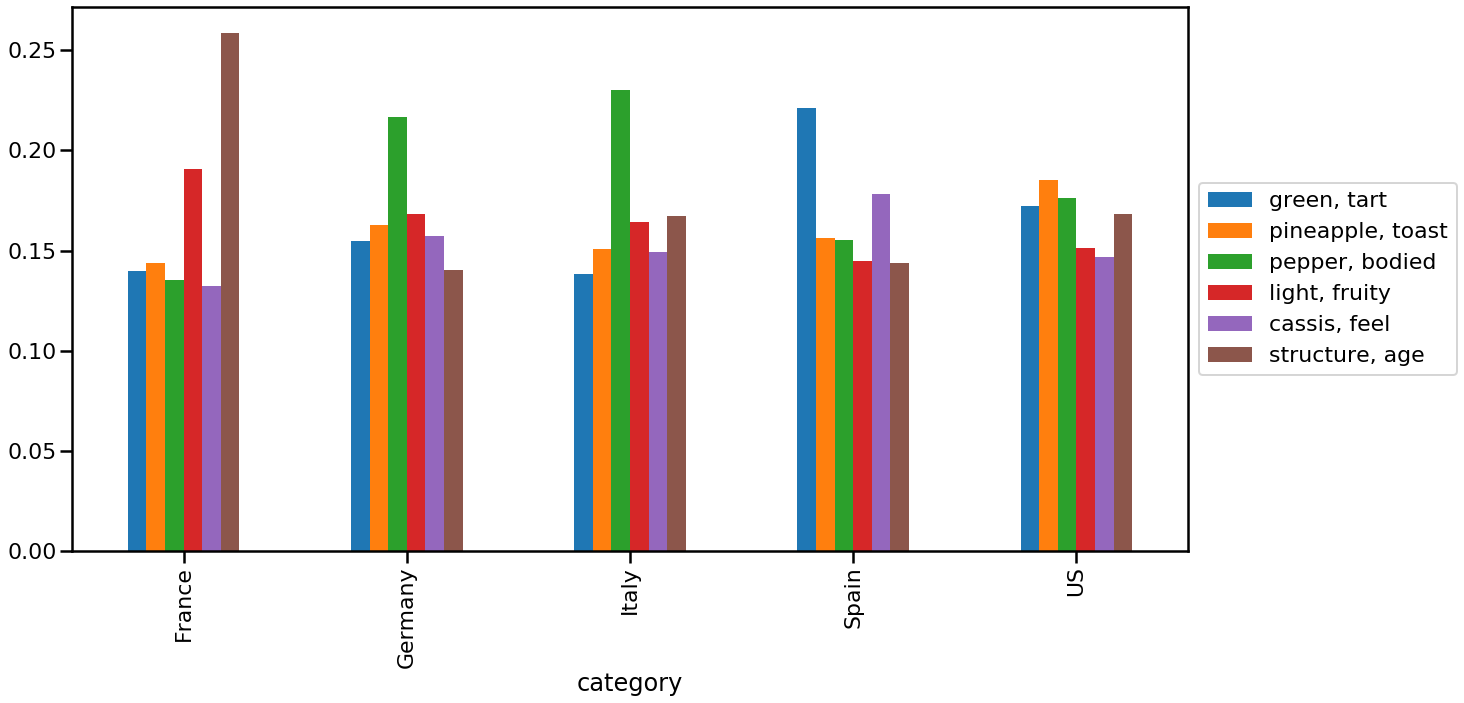

In [61]:
import matplotlib.pyplot as plt # make graphs
import seaborn # make prettier graphs

seaborn.set_context('poster') # use large font

fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.category.isin('Germany US Italy France Spain'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

# Guided LDA

In [40]:
import numpy as np
import guidedlda
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorize input
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1), min_df=100, max_df=0.1, stop_words='english')
X = vectorizer.fit_transform(df.description_cleaned[:50000].tolist())

# store lookup structures for convenience
vocab = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))

print(X.shape)

(50000, 1147)


In [41]:
# define topic seeds based on intuition
indicators = {
    'BRIGHT': ["fruity", "crisp", "bright"],
    'SPICE': ["licorice", "pepper", 'spice'], 
    'GREEN FRUIT': ["apple", "lemon", "citrus", "peach", "pear"],
    'DARK': ["vanilla", "smoke", "leather"],
    'RED FRUIT': ["strawberry", "raspberry", 'cherries'],
    'FOOD': ["pair", "food", "steak"],
    'FULL': ["bodied", "smoke", "medium", "vanilla"],
    'AGEING': ["age", "year", "structure"]
}

topic_names, seed_topic_list = zip(*indicators.items())
# filter out all words not actually in vocab
seed_topic_list = [[w for w in words if w in set(vocab)] for words in seed_topic_list]
    
# create a mapping {word_id: k}, which we need for the model
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
print(seed_topic_list)

[['fruity', 'crisp', 'bright'], ['licorice', 'pepper'], ['apple', 'lemon', 'citrus', 'peach', 'pear'], ['vanilla', 'smoke', 'leather'], ['strawberry', 'raspberry'], ['pair', 'food', 'steak'], ['bodied', 'smoke', 'medium', 'vanilla'], ['age', 'year', 'structure']]


In [42]:
# define model
model = guidedlda.GuidedLDA(n_topics=len(seed_topic_list), n_iter=1000, random_state=7, refresh=50, alpha=0.5, eta=0.000001)

# fit the model with seeds
doc_topic = model.fit_transform(X, seed_topics=seed_topics, seed_confidence=10)

# retrieve the word descriptors
n_top_words = 5
topic_word = model.topic_word_
descriptors_guided = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: "{}"'.format(topic_names[i], '" "'.join(topic_words)))
    descriptors_guided.append(' '.join(topic_words[:2]))

INFO:guidedlda:n_documents: 50000
INFO:guidedlda:vocab_size: 1147
INFO:guidedlda:n_words: 655859
INFO:guidedlda:n_topics: 8
INFO:guidedlda:n_iter: 1000
/Users/dirkhovy/anaconda3/lib/python3.6/site-packages/guidedlda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:guidedlda:<0> log likelihood: -5810907
INFO:guidedlda:<50> log likelihood: -4559110
INFO:guidedlda:<100> log likelihood: -4536596
INFO:guidedlda:<150> log likelihood: -4528082
INFO:guidedlda:<200> log likelihood: -4523979
INFO:guidedlda:<250> log likelihood: -4521397
INFO:guidedlda:<300> log likelihood: -4518840
INFO:guidedlda:<350> log likelihood: -4516004
INFO:guidedlda:<400> log likelihood: -4514875
INFO:guidedlda:<450> log likelihood: -4514327
INFO:guidedlda:<500> log likelihood: -4512189
INFO:guidedlda:<550> log likelihoo

Topic BRIGHT: "crisp" "bright" "fruity" "light" "texture"
Topic SPICE: "pepper" "licorice" "herb" "leather" "dark"
Topic GREEN FRUIT: "apple" "citrus" "peach" "white" "lemon"
Topic DARK: "feel" "herbal" "dark" "bit" "earthy"
Topic RED FRUIT: "raspberry" "strawberry" "tart" "high" "alcohol"
Topic FOOD: "make" "pair" "mouthfeel" "tone" "open"
Topic FULL: "vanilla" "bodied" "medium" "toast" "make"
Topic AGEING: "year" "age" "structure" "firm" "wood"


In [45]:
# get a list of all the topic scores for each document
# scores = [[t[1] for t in topic_corpus[entry]] for entry in range(50000)]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros_guided = pd.DataFrame(data=model.doc_topic_, columns=descriptors_guided)
# add the review category of each document (so we can aggregate)
topic_distros_guided['category'] = df[target_category][:50000]

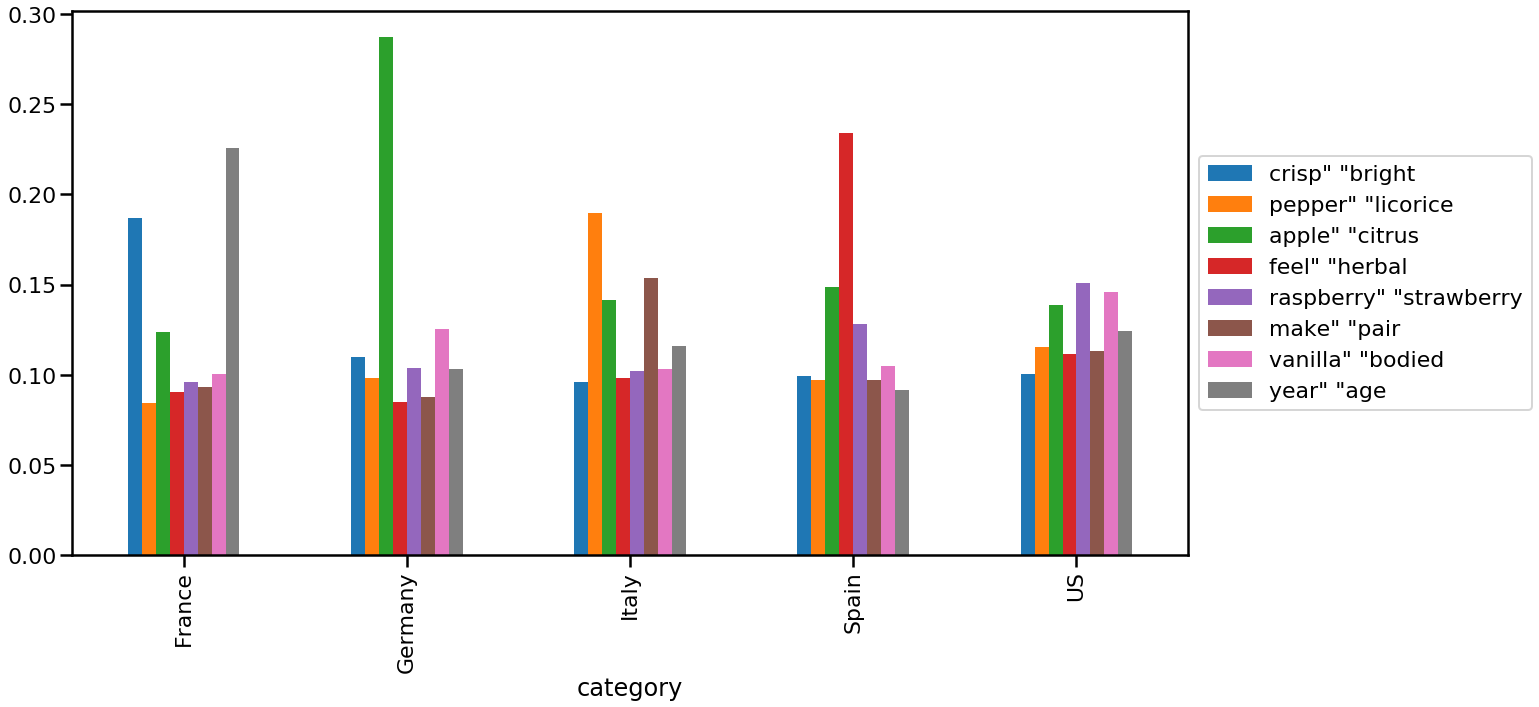

In [50]:
fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by review categories
aggregate_by_category = topic_distros_guided[topic_distros_guided.category.isin('Germany US Italy France Spain'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

# plot the graph
aggregate_by_category[descriptors_guided].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

In [52]:
descriptors_guided

['crisp" "bright',
 'pepper" "licorice',
 'apple" "citrus',
 'feel" "herbal',
 'raspberry" "strawberry',
 'make" "pair',
 'vanilla" "bodied',
 'year" "age']